In [327]:
import pandas as pd
import numpy as np
import arff
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, ttest_ind
from statsmodels.stats.proportion import proportions_ztest
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, confusion_matrix, roc_curve, auc
from scipy.stats import mannwhitneyu
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score


In [328]:
arff_data = arff.load(open("../data/raw/dataset_churn.arff", "r"))
arff_data

{'description': 'Content\nChurn for bank customers\nRowNumbercorresponds to the record (row) number and has no effect on the output.\nCustomerIdcontains random values and has no effect on customer leaving the bank.\nSurnamethe surname of a customer has no impact on their decision to leave the bank.\nCreditScorecan have an effect on customer churn, since a customer with a higher credit score is less likely to leave the bank.\nGeographya customers location can affect their decision to leave the bank.\nGenderits interesting to explore whether gender plays a role in a customer leaving the bank.\nAgethis is certainly relevant, since older customers are less likely to leave their bank than younger ones.\nTenurerefers to the number of years that the customer has been a client of the bank. Normally, older clients are more loyal and less likely to leave a bank.\nBalancealso a very good indicator of customer churn, as people with a higher balance in their accounts are less likely to leave the ba

In [329]:
# Convert the ARFF data to a pandas DataFrame
df = pd.DataFrame(arff_data["data"], columns=[attr[0] for attr in arff_data["attributes"]])

df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [330]:
df.shape

(10000, 14)

In [331]:
df.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [332]:
df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [333]:
df["CustomerId"].nunique()

10000

In [334]:
#df.to_csv("../data/raw/dataset_churn.csv", index=True)

In [335]:
df_churn = df.drop(["RowNumber", "CustomerId", "Surname"], axis=1)
df_churn

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [336]:
df_churn.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [337]:
# Calculate churn rate
total_customers = df_churn.shape[0]
churned_customers = df_churn[df_churn["Exited"] == 1].shape[0]

# Churn rate calculation
churn_rate = (churned_customers / total_customers) * 100
churn_rate

20.369999999999997

### General Analysis

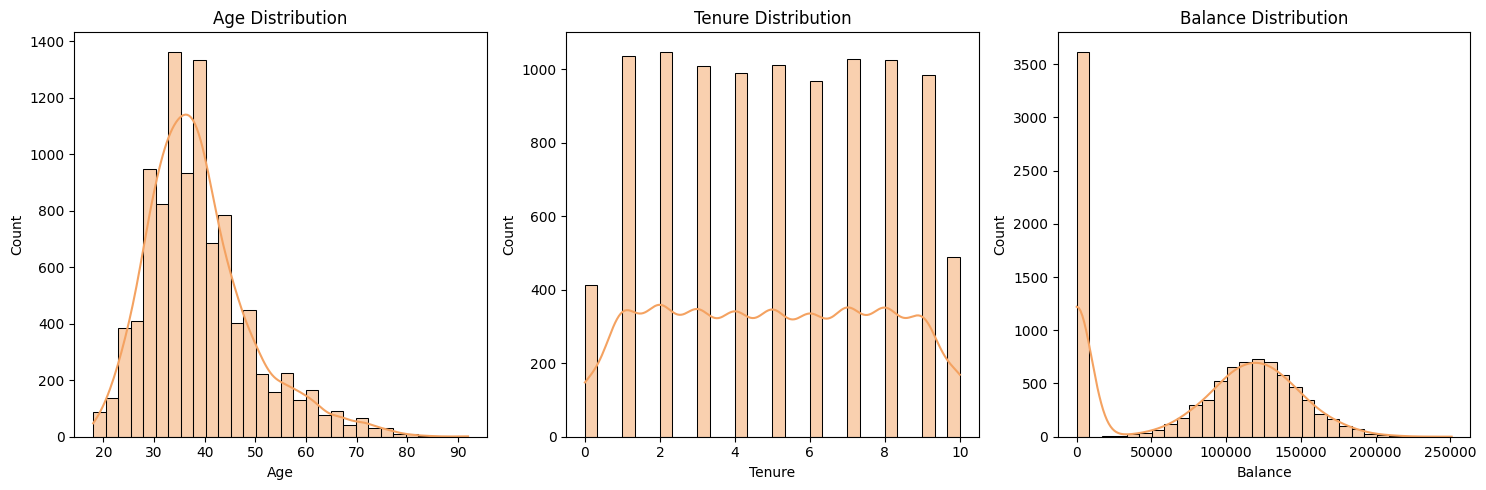

In [680]:
#custom_palette = ["#dc9526", "#0c2054"]

# General Analysis
plt.figure(figsize=(15,5))

# Age Distribution 
plt.subplot(1,3,1)
sns.histplot(df_churn["Age"], bins=30, kde=True, color="#f4a261")
plt.title("Age Distribution")


# Tenure Distribution
plt.subplot(1,3, 2)
sns.histplot(df_churn["Tenure"], bins=30, kde=True, color="#f4a261")
plt.title("Tenure Distribution")


# Balance Distribution 
plt.subplot(1,3, 3)
sns.histplot(df_churn["Balance"], bins=30, kde=True, color="#f4a261")
plt.title("Balance Distribution")

# Show the plots
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Number of Products')

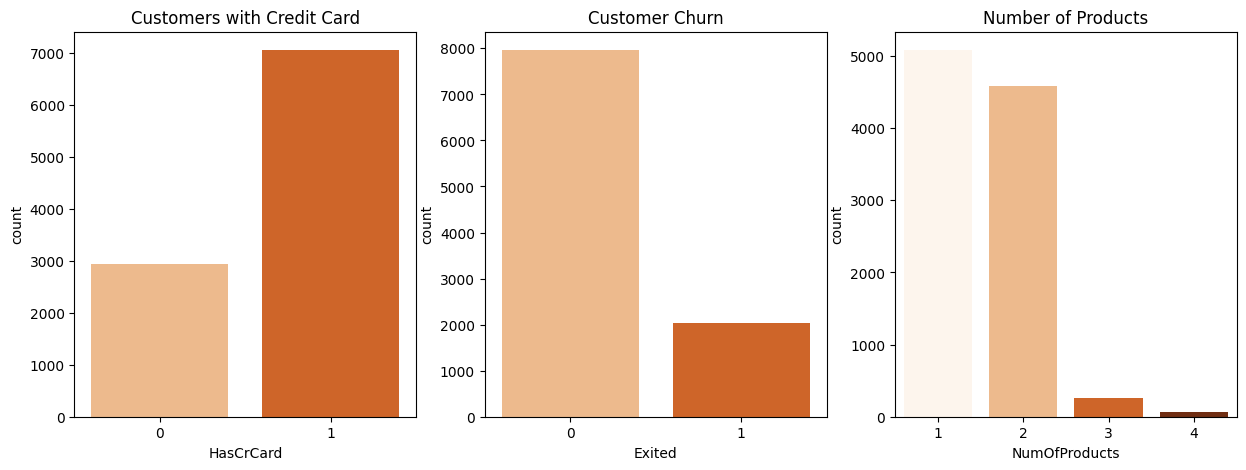

In [679]:
plt.figure(figsize=(15,5))

# Has card Distribution 
plt.subplot(1,3,1)
sns.countplot(x="HasCrCard", data=df_churn, hue= "HasCrCard", legend= False, palette="Oranges")
plt.title("Customers with Credit Card")

# Customer Churn 
plt.subplot(1,3,2)
sns.countplot(x="Exited", data=df_churn, hue= "Exited", legend= False, palette="Oranges")
plt.title("Customer Churn")

#Number of products
plt.subplot(1,3,3)
sns.countplot(x="NumOfProducts", data=df_churn, hue= "NumOfProducts", legend= False, palette="Oranges")
plt.title("Number of Products")



### Analysis Churn Rates

In [339]:
#Checking the values
df_new = df_churn.groupby("Geography")["Exited"].value_counts().unstack(fill_value=0)
df_new["Total"] = df_new[0] + df_new[1]
df_new["Percentage_Exited"] = df_new[1] / df_new["Total"] * 100

print(df_new)

Exited        0    1  Total  Percentage_Exited
Geography                                     
France     4204  810   5014          16.154767
Germany    1695  814   2509          32.443204
Spain      2064  413   2477          16.673395


In [340]:
#Checking values
df_churn["Geography"].value_counts()

Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

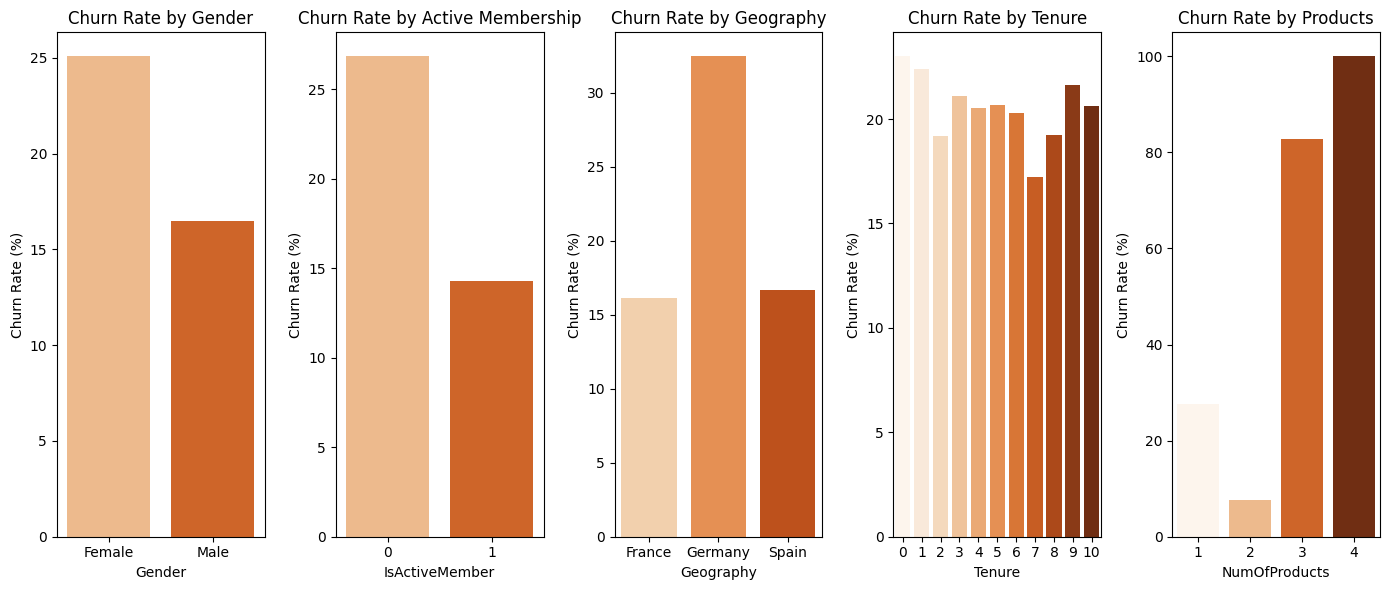

In [681]:
# Calculate the churn rate by Gender, IsActiveMember and Geography
churn_rate_by_gender = df_churn.groupby("Gender")["Exited"].apply(lambda x: (x.sum() / x.count()) * 100)
churn_rate_by_active = df_churn.groupby("IsActiveMember")["Exited"].apply(lambda x: (x.sum() / x.count()) * 100)
churn_rate_by_geography = df_churn.groupby("Geography")["Exited"].apply(lambda x: (x.sum() / x.count()) * 100)
churn_rate_by_tenure = df_churn.groupby("Tenure")["Exited"].apply(lambda x: (x.sum() / x.count()) * 100)
churn_rate_by_product =df_churn.groupby("NumOfProducts")["Exited"].apply(lambda x: (x.sum() / x.count()) * 100)

plt.figure(figsize=(14, 6))

# Churn rate by Gender
plt.subplot(1, 5, 1)
sns.barplot(x=churn_rate_by_gender.index, y=churn_rate_by_gender.values, hue= churn_rate_by_gender.index, legend= False, palette="Oranges")
plt.title("Churn Rate by Gender")
plt.ylabel("Churn Rate (%)")

# Churn rate by IsActiveMember
plt.subplot(1, 5, 2)
sns.barplot(x=churn_rate_by_active.index, y=churn_rate_by_active.values, hue= churn_rate_by_active.index, legend= False, palette="Oranges")
plt.title("Churn Rate by Active Membership")
plt.ylabel("Churn Rate (%)")

# Churn rate by Geography
plt.subplot(1, 5, 3)
sns.barplot(x=churn_rate_by_geography.index, y=churn_rate_by_geography.values, hue=churn_rate_by_geography.index, legend= False, palette="Oranges")
plt.title("Churn Rate by Geography")
plt.ylabel("Churn Rate (%)")

# Churn rate by Tenure
plt.subplot(1, 5, 4)
sns.barplot(x=churn_rate_by_tenure.index, y=churn_rate_by_tenure.values, hue=churn_rate_by_tenure.index, legend= False, palette="Oranges")
plt.title("Churn Rate by Tenure")
plt.ylabel("Churn Rate (%)")

# Churn rate by Products
plt.subplot(1, 5, 5)
sns.barplot(x=churn_rate_by_product.index, y=churn_rate_by_product.values, hue=churn_rate_by_product.index, legend= False, palette="Oranges")
plt.title("Churn Rate by Products")
plt.ylabel("Churn Rate (%)")

plt.tight_layout()
plt.show()

In [551]:
# Datasets to csv files for Tableau
churn_rate_gender_df = churn_rate_by_gender.reset_index(name="Churn Rate by Gender")
churn_rate_active_df = churn_rate_by_active.reset_index(name="Churn Rate by Active Membership")
churn_rate_geography_df = churn_rate_by_geography.reset_index(name="Churn Rate by Geography")
churn_rate_tenure_df = churn_rate_by_tenure.reset_index(name="Churn Rate by Tenure")

churn_rate_gender_df.to_csv("../data/clean/churn_rate_by_gender.csv", index=False)
churn_rate_active_df.to_csv("../data/clean/churn_rate_by_active_membership.csv", index=False)
churn_rate_geography_df.to_csv("../data/clean//churn_rate_by_geography.csv", index=False)
churn_rate_tenure_df.to_csv("../data/clean/churn_rate_by_tenure.csv", index=False)

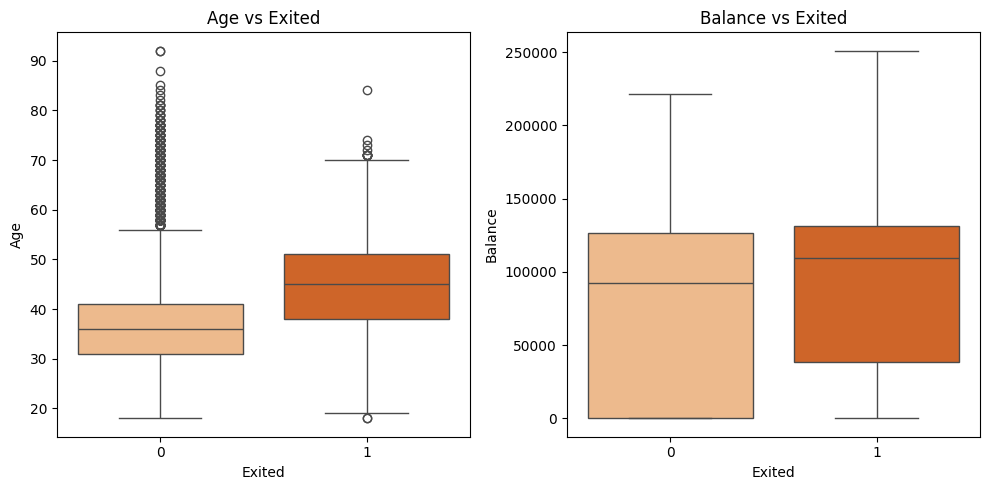

In [579]:

fig, axes = plt.subplots(1, 2, figsize=(10,5))

# Relationship between Age and Exited
sns.boxplot(x="Exited", y="Age", data=df_churn, ax=axes[0], hue="Exited", legend= False, palette="Oranges")
axes[0].set_title("Age vs Exited")

# Relationship between Balance and Exited
sns.boxplot(x="Exited", y="Balance", data=df_churn, ax=axes[1], hue="Exited", legend= False,palette="Oranges")
axes[1].set_title("Balance vs Exited")

plt.tight_layout()
plt.show()


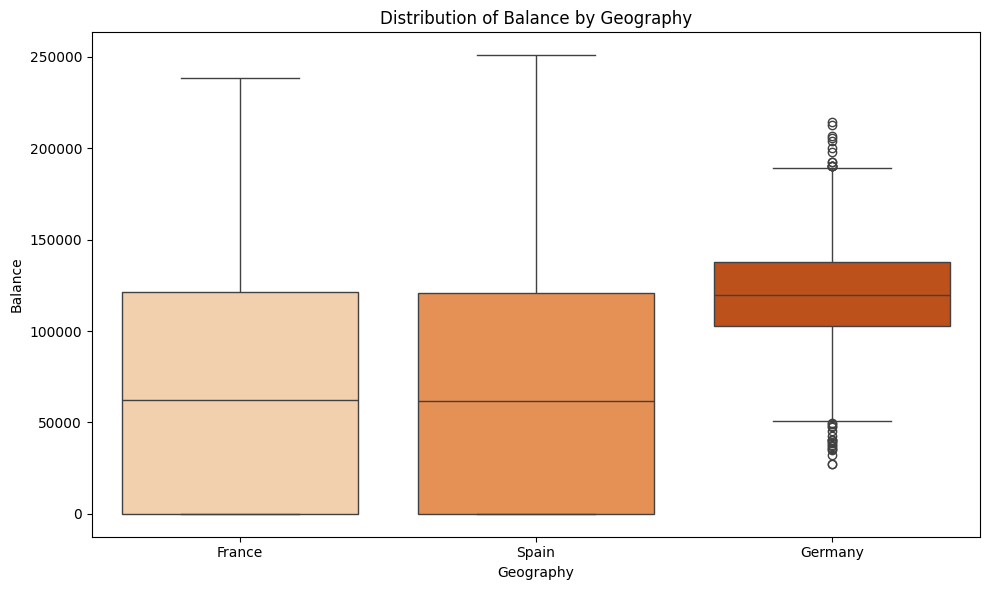

In [580]:
sns.set_palette("Oranges")

# Distribution of Balance by Geography
plt.figure(figsize=(10, 6))
sns.boxplot(x="Geography", y="Balance", data=df_churn,hue= "Geography", legend= False, palette="Oranges")
plt.title("Distribution of Balance by Geography")
plt.tight_layout()
plt.show()

### Hypothesis testing

#### H0 = Active members are equally or more likely to churn compared to inactive members

In [344]:
# Both columns ("Exited " and "IsActiveMember") are categorical, then it is necessary to use Chi-square test

chi2_active, p_active, _, _ = chi2_contingency(pd.crosstab(df_churn["IsActiveMember"], df_churn["Exited"]))

print(f"Chi-Square Statistic: {chi2_active:.2f}")
print(f"p-value: {p_active:.2e}")

alpha = 0.05

if p_active < alpha:
    print("Reject H0. There is a significant difference between active and inactive members regarding churn.")
else:
    print("Fail to reject H0. No significant difference between active and inactive members regarding churn.")


Chi-Square Statistic: 242.99
p-value: 8.79e-55
Reject H0. There is a significant difference between active and inactive members regarding churn.


In [345]:
churned_inactive = df_churn[(df_churn["IsActiveMember"] == 0) & (df_churn["Exited"] == 1)].shape[0]#.count() # number of inactive members
total_inactive = df_churn[df_churn["IsActiveMember"] == 0].shape[0] # total numbers of inactive members

churned_active = df_churn[(df_churn["IsActiveMember"] == 1) & (df_churn["Exited"] == 1)].shape[0]
total_active = df_churn[df_churn["IsActiveMember"] == 1].shape[0]

# One-sided z-test for proportions
count = [churned_inactive, churned_active]
totals = [total_inactive, total_active]

z_stat, p_value = proportions_ztest(count, totals, alternative="larger")

print(f"z-statistic: {z_stat:.2f}")
print(f"p-value: {p_value:.2e}")

alpha = 0.05

if p_value < alpha:
    print("Reject H0. Active members are significantly less likely to churn than inactive members.")
else:
    print("Fail to reject H0. There is no significant difference in churn rates between active and inactive members.")

z-statistic: 15.61
p-value: 2.98e-55
Reject H0. Active members are significantly less likely to churn than inactive members.


In [346]:
# Checking results for Churn rate per Active member
churn_rates = df_churn.groupby("IsActiveMember")["Exited"].mean()
churn_rates

IsActiveMember
0    0.268509
1    0.142691
Name: Exited, dtype: float64

#### H0 = Customers with higher balances are equally likely or more likely to churn compared to those with lower balances

In [347]:
balance_churned = df_churn[df_churn["Exited"] == 1]["Balance"]
balance_not_churned = df_churn[df_churn["Exited"] == 0]["Balance"]

# Independent two sample ttest 
t_stat_balance, p_value_balance = ttest_ind(balance_churned, balance_not_churned, alternative="greater", equal_var=False) # equal_var=False: in case of different variances

print(f"t-statistic: {t_stat_balance:.2f}")
print(f"p-value: {p_value_balance:.2e}")

alpha = 0.05

if p_value_balance < alpha:
    print("Reject H0: Customers with higher balances are less likely to churn compared to those with lower balances.") 
else:
    print("Fail to reject H0: There is no statistically significant evidence that customers with higher balances are less likely to churn.")


t-statistic: 12.47
p-value: 3.16e-35
Reject H0: Customers with higher balances are less likely to churn compared to those with lower balances.


In [348]:
# Ho : mean_balance_churned - mean_balance_not_churned <= 0
# H1: mean_balance_churned - mean_balance_not_churned > 0

#mean_balance_churned = balance_churned.mean()
#mean_balance_not_churned = balance_not_churned.mean()

#print(f"Mean balance for churned customers: {mean_balance_churned}")
#print(f"Mean balance for non-churned customers: {mean_balance_not_churned}")

#if mean_balance_churned > mean_balance_not_churned:
#    print("Churned customers tend to have higher balances on average.")
#else:
#    print("Non-churned customers tend to have higher balances on average.")

### H0 = Older customers are equally or less likely to churn compared to younger customers

In [349]:
age_churned = df_churn[df_churn["Exited"] == 1]["Age"]
age_not_churned = df_churn[df_churn["Exited"] == 0]["Age"]

# Independent two sample ttest 
t_age, p_age = ttest_ind(age_churned, age_not_churned, alternative="greater", equal_var=False) # equal_var=False : in case of different variances

print(f"t-statistic: {t_age:.2f}")
print(f"p-value: {p_age:.2e}")

alpha = 0.05

if p_age < alpha:
    print("Reject H0. Older customers are significantly more likely to churn.")
else:
    print("Fail to reject H0. Age does not significantly affect churn.")

t-statistic: 30.42
p-value: 2.36e-179
Reject H0. Older customers are significantly more likely to churn.


In [350]:
mean_age_churned = age_churned.mean()
mean_age_not_churned = age_not_churned.mean()

print(f"Mean age for churned customers: {mean_age_churned}")
print(f"Mean age for non-churned customers: {mean_age_not_churned}")

#if mean_balance_churned > mean_balance_not_churned:
#    print("Churned customers tend to have higher age on average.")
#else:
#    print("Non-churned customers tend to have higher age on average.")

Mean age for churned customers: 44.8379970544919
Mean age for non-churned customers: 37.40838879819164


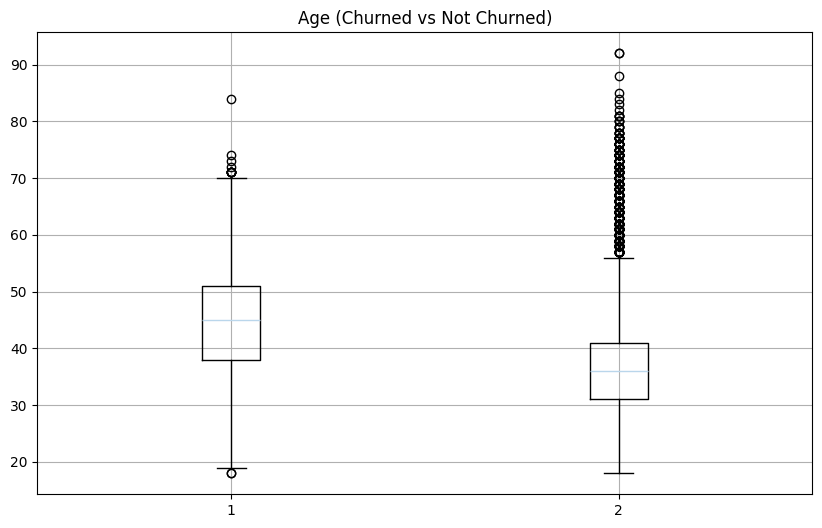

(1410    73
 2141    18
 2553    71
 3110    74
 3317    71
 3531    84
 5664    71
 6581    71
 7058    71
 7499    71
 9555    72
 9572    18
 9646    71
 Name: Age, dtype: int64,
 42      61
 44      61
 85      75
 158     73
 181     65
         ..
 9897    61
 9909    58
 9936    77
 9939    57
 9979    58
 Name: Age, Length: 486, dtype: int64)

In [351]:
# Check for outliers using boxplot 
plt.figure(figsize=(10, 6))

plt.boxplot([age_churned, age_not_churned])
plt.title("Age (Churned vs Not Churned)")
plt.grid(True)

plt.show()

# Check for outliers using IQR 
# Calculate IQR for churned customers
q1_churned, q3_churned = np.percentile(age_churned, [25, 75])
iqr_churned = q3_churned - q1_churned
lower_bound_churned = q1_churned - 1.5 * iqr_churned
upper_bound_churned = q3_churned + 1.5 * iqr_churned

# Calculate IQR for not churned customers
q1_not_churned, q3_not_churned = np.percentile(age_not_churned, [25, 75])
iqr_not_churned = q3_not_churned - q1_not_churned
lower_bound_not_churned = q1_not_churned - 1.5 * iqr_not_churned
upper_bound_not_churned = q3_not_churned + 1.5 * iqr_not_churned

# Identify outliers in both groups
outliers_churned = age_churned[(age_churned < lower_bound_churned) | (age_churned > upper_bound_churned)]
outliers_not_churned = age_not_churned[(age_not_churned < lower_bound_not_churned) | (age_not_churned > upper_bound_not_churned)]

outliers_churned, outliers_not_churned


In [352]:
# Remove outliers 
age_churned_no_outliers = age_churned[(age_churned >= lower_bound_churned) & (age_churned <= upper_bound_churned)]
age_not_churned_no_outliers = age_not_churned[(age_not_churned >= lower_bound_not_churned) & (age_not_churned <= upper_bound_not_churned)]

t_stat_no_outliers, p_value_no_outliers = ttest_ind(age_churned_no_outliers, age_not_churned_no_outliers, alternative="greater", equal_var=False)

# Mann-Whitney U test
mannwhitney_stat, mannwhitney_p_value = mannwhitneyu(age_churned, age_not_churned, alternative="greater")

(t_stat_no_outliers, p_value_no_outliers), (mannwhitney_stat, mannwhitney_p_value)

((np.float64(40.18290221634959), np.float64(8.040859732461101e-277)),
 (np.float64(11874649.5), np.float64(1.6052007159685838e-230)))

In [353]:
# Both methods confirm that older customers are significantly more likely to churn compared to younger customers.

### H0 = There is no significant difference in churn rates across different geographical regions

In [354]:
contingency_table_geo = pd.crosstab(df_churn["Geography"], df_churn["Exited"])
chi2_geo, p_geo, _, _ = chi2_contingency(contingency_table_geo)

print(f"Chi-Square Statistic: {chi2_geo:.2f}")
print(f"p-value: {p_geo:.5f}")


alpha = 0.05
if p_geo < alpha:
    print("Reject H0. Churn rates vary significantly by geography.")
else:
    print("Fail to reject H0. There is no significant difference in churn rates by geography.")

Chi-Square Statistic: 301.26
p-value: 0.00000
Reject H0. Churn rates vary significantly by geography.


In [355]:
german_customers = df_churn[df_churn["Geography"] == "Germany"]

# Churn rate by age 
age_churn_germany = german_customers.groupby("Exited")["Age"].mean()

# Churn rate by balance 
balance_churn_germany = german_customers.groupby("Exited")["Balance"].mean()

# Churn rate by number of products 
products_churn_germany = german_customers.groupby("Exited")["NumOfProducts"].mean()

# Churn rate by activity status 
activity_churn_germany = german_customers.groupby("Exited")["IsActiveMember"].mean()

# Churn rate by gender 
gender_churn_germany = german_customers.groupby(["Exited", "Gender"]).size().unstack().apply(lambda x: x / x.sum() * 100, axis=1)

germany_churn_analysis = {
    "Attribute": ["Average Age", "Average Balance", "Average Number of Products", "Activity (IsActiveMember)"],
    "Non-Churned (0)": [age_churn_germany[0], balance_churn_germany[0], products_churn_germany[0], activity_churn_germany[0]],
    "Churned (1)": [age_churn_germany[1], balance_churn_germany[1], products_churn_germany[1], activity_churn_germany[1]]
}

churn_analysis_df = pd.DataFrame(germany_churn_analysis)
print("Churn Analysis for Germany:")
display(churn_analysis_df)

print("\nChurn Rate by Gender for Germany (%):")
display(gender_churn_germany)


Churn Analysis for Germany:


,Attribute,Non-Churned (0),Churned (1)
0,Average Age,37.311504,44.894349
1,Average Balance,119427.106696,120361.075590
2,Average Number of Products,1.551032,1.454545
3,Activity (IsActiveMember),0.561652,0.363636



Churn Rate by Gender for Germany (%):


Gender,Female,Male
Exited,,
0,43.952802,56.047198
1,55.036855,44.963145


In [556]:
#gender_churn_germany = pd.DataFrame()

#gender_churn_germany.to_csv("../data/clean/gender_churn_germany.csv", index=False)

#churn_analysis_df.to_csv("../data/clean/german_churn_analysis_df.csv", index=False)

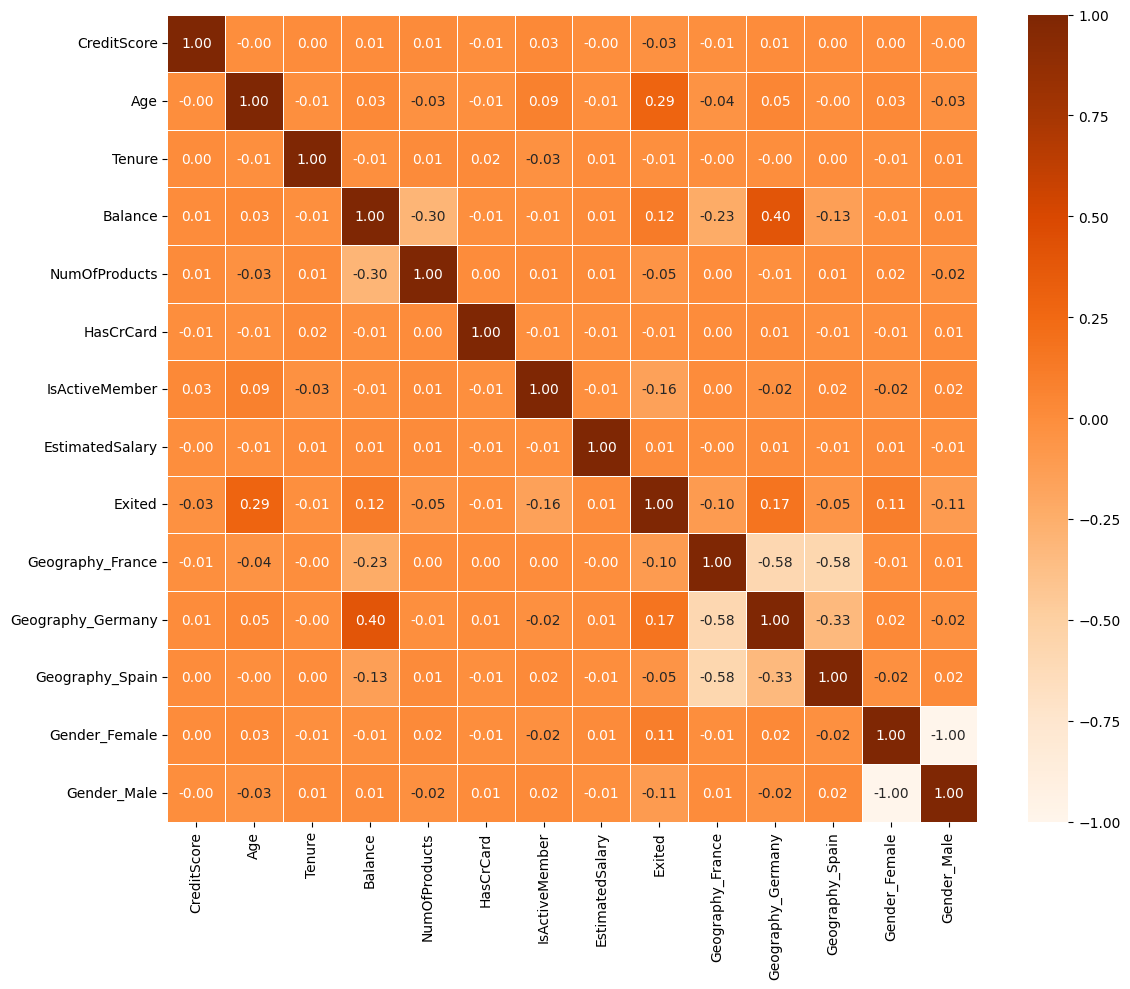

In [581]:
# Encoding categorical columns
df_encoded = pd.get_dummies(df_churn, columns=["Geography", "Gender"])

correlation_matrix_encoded = df_encoded.corr()

# Plotting the heatmap of the correlation matrix with encoded columns
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_encoded, annot=True, cmap="Oranges", fmt=".2f", linewidths=0.5)

plt.tight_layout()
plt.show()

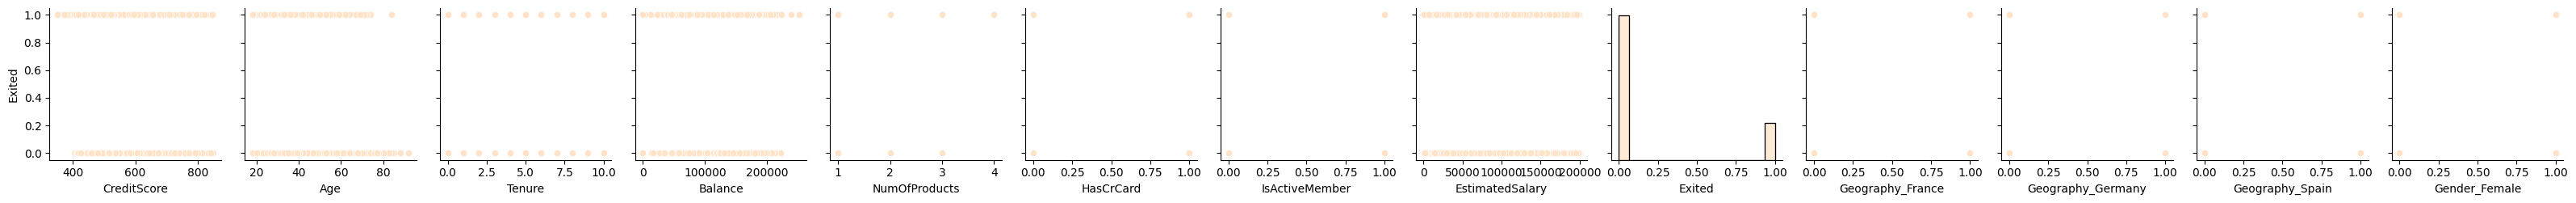

In [582]:
sns.pairplot(df_encoded, y_vars=["Exited"], x_vars=df_encoded.columns[:-1], kind="scatter");

In [358]:
features = df_encoded.drop(columns = ["Exited"])
target = df_encoded["Exited"]

In [359]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=0)

### KNN Classifier

In [360]:
knn = KNeighborsClassifier(n_neighbors=10)

In [361]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [362]:
pred = knn.predict(X_test)
pred

array([0, 0, 0, ..., 0, 0, 0])

In [363]:
y_test.values

array([0, 1, 0, ..., 0, 0, 0])

In [364]:
print(f"The accuracy of the model is {knn.score(X_test, y_test)*100: .2f}%")

The accuracy of the model is  79.35%


### Normalization

In [365]:
normalizer = MinMaxScaler()

In [366]:
normalizer.fit(X_train)

MinMaxScaler()

In [367]:
X_train_norm = normalizer.transform(X_train)

X_test_norm = normalizer.transform(X_test)

In [368]:
X_train_norm = pd.DataFrame(X_train_norm, columns=X_train.columns, index=X_train.index ) # Here index is used keep the rows with the same index as in the df
X_train_norm.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
7389,0.634,0.228571,0.5,0.000000,0.333333,1.0,0.0,0.819174,0.0,0.0,1.0,1.0,0.0
9275,0.154,0.342857,0.1,0.317473,0.000000,1.0,1.0,0.285459,0.0,1.0,0.0,0.0,1.0
2995,0.370,0.157143,0.2,0.471364,0.000000,1.0,0.0,0.928185,1.0,0.0,0.0,1.0,0.0
5316,0.608,0.314286,0.5,0.443327,0.000000,1.0,0.0,0.868110,0.0,0.0,1.0,0.0,1.0
356,1.000,0.557143,0.8,0.531808,0.333333,1.0,1.0,0.661498,0.0,0.0,1.0,1.0,0.0


In [369]:
X_test_norm = pd.DataFrame(X_test_norm, columns=X_test.columns, index=X_test.index)
X_test_norm.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
9394,0.494,0.242857,0.8,0.549949,0.000000,1.0,1.0,0.964298,0.0,1.0,0.0,1.0,0.0
898,0.346,0.314286,0.2,0.431933,0.000000,1.0,0.0,0.643514,1.0,0.0,0.0,1.0,0.0
2398,0.712,0.342857,0.8,0.400133,0.000000,1.0,1.0,0.378640,0.0,0.0,1.0,1.0,0.0
5906,0.876,0.200000,0.4,0.470157,0.000000,0.0,0.0,0.446828,1.0,0.0,0.0,0.0,1.0
2343,0.712,0.285714,0.5,0.683907,0.333333,1.0,1.0,0.678318,0.0,1.0,0.0,0.0,1.0


In [370]:
knn = KNeighborsClassifier(n_neighbors=10)

In [371]:
knn.fit(X_train_norm, y_train)

KNeighborsClassifier(n_neighbors=10)

In [372]:
print(f"The accuracy of the model is {knn.score(X_test_norm, y_test)*100: .2f}%")

The accuracy of the model is  81.90%


### StandardScaler

In [373]:
scaler = StandardScaler()

In [374]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [375]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

In [376]:
X_train_scaled_df.columns

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Geography_France',
       'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male'],
      dtype='object')

In [377]:
X_train_scaled_df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
7389,0.169582,-0.464608,0.006661,-1.215717,0.809503,0.642595,-1.032270,1.106432,-1.014607,-0.569844,1.743090,1.091687,-1.091687
9275,-2.304559,0.301026,-1.377440,-0.006312,-0.921591,0.642595,0.968738,-0.748664,-1.014607,1.754865,-0.573694,-0.916013,0.916013
2995,-1.191196,-0.943129,-1.031415,0.579935,-0.921591,0.642595,-1.032270,1.485335,0.985604,-0.569844,-0.573694,1.091687,-1.091687
5316,0.035566,0.109617,0.006661,0.473128,-0.921591,0.642595,-1.032270,1.276528,-1.014607,-0.569844,1.743090,-0.916013,0.916013
356,2.056114,1.736588,1.044737,0.810193,0.809503,0.642595,0.968738,0.558378,-1.014607,-0.569844,1.743090,1.091687,-1.091687


In [378]:
knn = KNeighborsClassifier(n_neighbors=10)

knn.fit(X_train_scaled, y_train)

y_pred_knn = knn.predict(X_test_scaled)

# Evaluation
accuracy_knn = accuracy_score(y_test, y_pred_knn)*100
classification_report_knn = classification_report(y_test, y_pred_knn)

print(f"KNN Accuracy: {accuracy_knn}%")
print(f"KNN Classification Report:\n{classification_report_knn}")




KNN Accuracy: 84.0%
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.97      0.91      1595
           1       0.73      0.33      0.46       405

    accuracy                           0.84      2000
   macro avg       0.79      0.65      0.68      2000
weighted avg       0.83      0.84      0.82      2000



### Logistic Regression

In [379]:
log_reg = LogisticRegression(random_state=0)

In [380]:
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(random_state=0)

In [381]:
y_pred_log_reg = log_reg.predict(X_test_scaled)

# Evaluation
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)* 100
classification_report_log_reg = classification_report(y_test, y_pred_log_reg)

print(f"Logistic Regression Accuracy: {accuracy_log_reg}%")
print(f"Logistic Regression Classification Report:\n{classification_report_log_reg}")

Logistic Regression Accuracy: 81.10000000000001%
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      1595
           1       0.58      0.24      0.34       405

    accuracy                           0.81      2000
   macro avg       0.71      0.60      0.61      2000
weighted avg       0.78      0.81      0.78      2000



### Bagging and Pasting

In [604]:
bagging_class = BaggingClassifier(DecisionTreeClassifier(max_depth=20),
                               n_estimators=100, # number of models to use
                               max_samples = 1000)

In [605]:
bagging_class.fit(X_train_scaled, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=20),
                  max_samples=1000, n_estimators=100)

In [606]:
y_pred_bagging = bagging_class.predict(X_test_scaled)

# Evaluation
accuracy_bagging = accuracy_score(y_test, y_pred_bagging)*100
classification_report_bagging = classification_report(y_test, y_pred_bagging)

print(f"Bagging Classifier Accuracy: {accuracy_bagging}%")
print(f"Bagging Classifier Classification Report:\n{classification_report_bagging}")

Bagging Classifier Accuracy: 86.56666666666666%
Bagging Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      2416
           1       0.79      0.43      0.55       584

    accuracy                           0.87      3000
   macro avg       0.83      0.70      0.74      3000
weighted avg       0.86      0.87      0.85      3000



### Random Forest

In [385]:
forest = RandomForestClassifier(random_state=0)

In [386]:
forest.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=0)

In [387]:
y_pred_rf = forest.predict(X_test_scaled)

# Evaluation
accuracy_rf = accuracy_score(y_test, y_pred_rf) *100
classification_report_rf = classification_report(y_test, y_pred_rf)

print(f"Random Forest Accuracy: {accuracy_rf}%")
print(f"Random Forest Classification Report:\n{classification_report_rf}")

Random Forest Accuracy: 86.7%
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1595
           1       0.75      0.51      0.61       405

    accuracy                           0.87      2000
   macro avg       0.82      0.73      0.76      2000
weighted avg       0.86      0.87      0.86      2000



### AdaBoost

In [388]:
ada_reg = AdaBoostClassifier(DecisionTreeClassifier(max_depth=20),
                            n_estimators=100)

In [389]:
ada_reg.fit(X_train_scaled, y_train)

c:\Users\lored\Documents\Ironhack\Project\final_project\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=20),
                   n_estimators=100)

In [390]:
y_pred_ada = ada_reg.predict(X_test_scaled)


# Evaluation
accuracy_ada = accuracy_score(y_test, y_pred_ada)* 100
classification_report_ada = classification_report(y_test, y_pred_ada)

print(f"AdaBoost Classifier Accuracy: {accuracy_ada}%")
print(f"AdaBoost Classifier Classification Report:\n{classification_report_ada}")

AdaBoost Classifier Accuracy: 84.39999999999999%
AdaBoost Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      1595
           1       0.68      0.43      0.53       405

    accuracy                           0.84      2000
   macro avg       0.77      0.69      0.72      2000
weighted avg       0.83      0.84      0.83      2000



### Gradient Boosting

In [391]:
gb_reg = GradientBoostingClassifier(random_state=0)

In [392]:
gb_reg.fit(X_train_scaled, y_train)

GradientBoostingClassifier(random_state=0)

In [393]:
y_pred_gb = gb_reg.predict(X_test_scaled)

accuracy_gb = accuracy_score(y_test, y_pred_gb) *100
classification_report_gb = classification_report(y_test, y_pred_gb)

print(f"Gradient Boosting Accuracy: {accuracy_gb}%")
print(f"Gradient Boosting Classification Report:\n{classification_report_gb}")



Gradient Boosting Accuracy: 86.85000000000001%
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1595
           1       0.76      0.52      0.61       405

    accuracy                           0.87      2000
   macro avg       0.82      0.74      0.77      2000
weighted avg       0.86      0.87      0.86      2000



### Hyperparamenter Tuning

### Random Search

In [592]:
#param_dist = {
#    'n_estimators': [100, 200, 300, 400, 500],
#    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
#    'max_depth': [3, 4, 5, 6, 7],
#    'min_samples_split': [2, 5, 10],
#    'min_samples_leaf': [1, 2, 4]
#}

#gb = GradientBoostingClassifier(n_iter_no_change=10, validation_fraction=0.1)

#random_search = RandomizedSearchCV(estimator=gb, param_distributions=param_dist, n_iter=20, 
#                                   cv=3, n_jobs=-1, verbose=1, random_state=42, scoring='accuracy')

#random_search.fit(X_train_scaled, y_train)

# Get the best parameters and best estimator
#best_random_params = random_search.best_params_
#best_random_gb_model = random_search.best_estimator_

# Evaluation
#y_pred_best_random_gb = best_random_gb_model.predict(X_test_scaled)
#best_random_gb_test_accuracy = accuracy_score(y_test, y_pred_best_random_gb)

#print("Best Parameters:", best_random_params)
#print("Test Accuracy of Best Model:", best_random_gb_test_accuracy)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 7, 'learning_rate': 0.01}
Test Accuracy of Best Model: 0.869


In [ ]:
# OUtput
#Fitting 3 folds for each of 20 candidates, totalling 60 fits
#Best Parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 7, 'learning_rate': 0.01}
#Test Accuracy of Best Model: 0.869


In [607]:
final_gb = GradientBoostingClassifier (n_estimators= 300, min_samples_split= 10, min_samples_leaf= 1, max_depth= 7, learning_rate= 0.01, random_state=0)
final_gb.fit(X_train_scaled, y_train)

GradientBoostingClassifier(learning_rate=0.01, max_depth=7,
                           min_samples_split=10, n_estimators=300,
                           random_state=0)

In [608]:
y_pred_final_gb = final_gb.predict(X_test_scaled)

accuracy_final = accuracy_score(y_test, y_pred_final_gb)*100
classification_report_final = classification_report(y_test, y_pred_final_gb)

print(f"Gradient Boosting Tuning Classifier Accuracy: {accuracy_final}%")
print(f"Gradient Boosting Tuning Classification Report:\n{classification_report_final}")


Gradient Boosting Tuning Classifier Accuracy: 87.2%
Gradient Boosting Tuning Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      2416
           1       0.78      0.47      0.59       584

    accuracy                           0.87      3000
   macro avg       0.83      0.72      0.76      3000
weighted avg       0.86      0.87      0.86      3000



### Grid Search

In [596]:
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

In [503]:
#grid = {"max_leaf_nodes": [100, 200, 300],
#        "max_depth":[3, 5, 7]}

In [597]:
gb_reg1 = GradientBoostingClassifier(random_state=0)

In [599]:
model1 = GridSearchCV(estimator = gb_reg1, param_grid = param_grid, cv=5, verbose=10) 

In [600]:
#model1.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5; 1/32] START learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 1/5; 1/32] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.837 total time= 1.3min
[CV 2/5; 1/32] START learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 2/5; 1/32] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.834 total time= 1.2min
[CV 3/5; 1/32] START learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 3/5; 1/32] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.839 total time=  59.9s
[CV 4/5; 1/32] START learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 4/5; 1/32] END learning_rate=0.01, max_depth=3, min_sampl

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=0),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             verbose=10)

In [601]:
best_params= model1.best_params_
best_params

{'learning_rate': 0.1,
 'max_depth': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 200}

In [508]:
#final_gb = GradientBoostingClassifier(max_depth= 3, max_leaf_nodes = 100, random_state=0)
#final_gb.fit(X_train_scaled, y_train)

GradientBoostingClassifier(max_leaf_nodes=100, random_state=0)

In [609]:
final_gb_grid = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 5, min_samples_leaf = 2, min_samples_split = 2, n_estimators = 200, random_state=0)
final_gb_grid.fit(X_train_scaled, y_train)

GradientBoostingClassifier(max_depth=5, min_samples_leaf=2, n_estimators=200,
                           random_state=0)

In [509]:
#best_model = model.best_score_

In [610]:
y_pred_final_gb_grid = final_gb_grid.predict(X_test_scaled)

accuracy_final_grid = accuracy_score(y_test, y_pred_final_gb_grid)*100
classification_report_final_grid = classification_report(y_test, y_pred_final_gb_grid)

print(f"Gradient Boosting Tuning Classifier Accuracy: {accuracy_final_grid}%")
print(f"Gradient Boosting Tuning Classification Report:\n{classification_report_final_grid}")

Gradient Boosting Tuning Classifier Accuracy: 87.06666666666666%
Gradient Boosting Tuning Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      2416
           1       0.76      0.49      0.59       584

    accuracy                           0.87      3000
   macro avg       0.82      0.73      0.76      3000
weighted avg       0.86      0.87      0.86      3000



In [640]:
cv_scores = cross_val_score(final_gb, X_train_scaled, y_train, cv=5, scoring="accuracy")
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", cv_scores.mean())


Cross-Validation Accuracy Scores: [0.85571429 0.86214286 0.86571429 0.85928571 0.84857143]
Mean Cross-Validation Accuracy: 0.8582857142857143


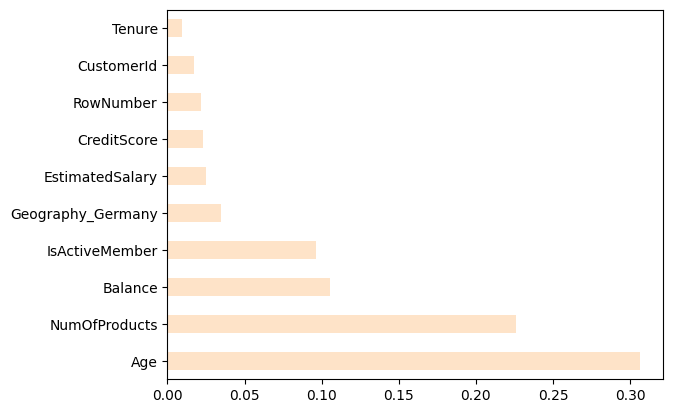

In [650]:
importances = final_gb.feature_importances_
feature_importance = pd.Series(importances, index=X_train.columns)
feature_importance.nlargest(10).plot(kind='barh')
plt.show()

In [614]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final_gb)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[2340   76]
 [ 308  276]]


### Imbalanced


In [514]:
df_churn["Exited"].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

### Oversampling

In [615]:
train = pd.DataFrame(X_train_scaled, columns = X_train.columns)

In [616]:
train["Exited"] = y_train.values

In [617]:
churned = train[train["Exited"] == 1]
no_churned = train[train["Exited"] == 0]

In [618]:
len(churned),len(no_churned)

(1453, 5547)

In [619]:
yes_oversampled = resample(churned,
                                    replace=True,
                                    n_samples = len(no_churned),
                                    random_state=0)

In [620]:
train_over = pd.concat([yes_oversampled, no_churned])
train_over

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,...,Surname_Zox,Surname_Zubarev,Surname_Zubareva,Surname_Zuev,Surname_Zuyev,Surname_Zuyeva,Geography_Germany,Geography_Spain,Gender_Male,Exited
3261,-0.606508,-0.882537,0.860905,0.390286,1.391718,0.358460,-0.903352,-1.548034,-1.030169,1.452488,...,0.0,0.0,-0.011953,-0.011953,-0.011953,0.0,1.737346,-0.577790,-1.098232,1
2550,-0.846049,1.350329,-1.196759,0.771027,0.351385,0.428136,-0.903352,0.645981,-1.030169,-1.466743,...,0.0,0.0,-0.011953,-0.011953,-0.011953,0.0,1.737346,-0.577790,-1.098232,1
5819,1.153822,-0.183575,-0.988914,1.722878,-1.382503,0.698144,-0.903352,0.645981,-1.030169,0.547127,...,0.0,0.0,-0.011953,-0.011953,-0.011953,0.0,1.737346,-0.577790,0.910554,1
4026,-1.243666,0.095013,0.466000,1.627692,0.004607,0.550324,-0.903352,0.645981,0.970714,-0.877544,...,0.0,0.0,-0.011953,-0.011953,-0.011953,0.0,-0.575591,1.730732,0.910554,1
3680,-0.010603,-0.912216,-1.560488,1.722878,-0.688948,0.400975,-0.903352,0.645981,-1.030169,-0.993092,...,0.0,0.0,-0.011953,-0.011953,-0.011953,0.0,1.737346,-0.577790,-1.098232,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6993,-1.583737,-0.380003,2.056014,-0.656750,1.391718,-1.222055,0.819663,0.645981,0.970714,-1.420515,...,0.0,0.0,-0.011953,-0.011953,-0.011953,0.0,-0.575591,1.730732,-1.098232,0
6994,0.426533,-0.920877,2.056014,-0.180824,0.351385,-1.222055,0.819663,0.645981,-1.030169,0.146828,...,0.0,0.0,-0.011953,-0.011953,-0.011953,0.0,-0.575591,-0.577790,0.910554,0
6995,0.242457,-1.308934,1.203850,1.437322,1.044940,-0.106936,-0.903352,0.645981,0.970714,-0.545387,...,0.0,0.0,-0.011953,-0.011953,-0.011953,0.0,-0.575591,-0.577790,0.910554,0
6996,0.054222,-0.131428,0.310116,1.818063,-1.382503,-1.222055,-0.903352,0.645981,0.970714,-1.736501,...,0.0,0.0,-0.011953,-0.011953,-0.011953,0.0,-0.575591,-0.577790,-1.098232,0


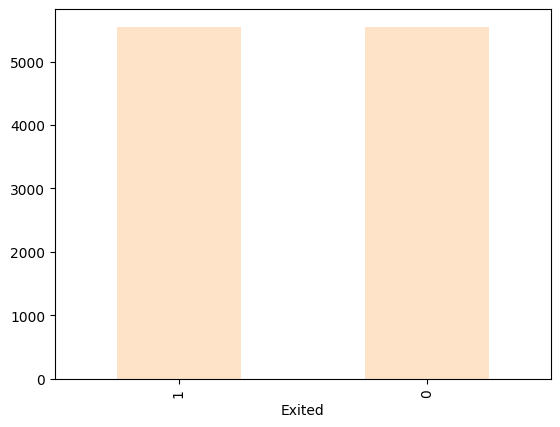

In [621]:
churned_plt = train_over["Exited"].value_counts()
churned_plt.plot(kind="bar")
plt.show()

In [622]:
X_train_over = train_over.drop(columns = ["Exited"])
y_train_over = train_over["Exited"]

In [623]:
final_gb_over = GradientBoostingClassifier (n_estimators= 300, min_samples_split= 10, min_samples_leaf= 1, max_depth= 7, learning_rate= 0.01, random_state=0)#(max_depth= 3, max_leaf_nodes = 100, random_state=0)
final_gb_over.fit(X_train_over, y_train_over)


GradientBoostingClassifier(learning_rate=0.01, max_depth=7,
                           min_samples_split=10, n_estimators=300,
                           random_state=0)

In [627]:
y_pred_over = final_gb_over.predict(X_test_scaled)

print("Oversampling Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_over)*100 }%")
print(classification_report(y_test, y_pred_over))

c:\Users\lored\Documents\Ironhack\Project\final_project\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


Oversampling Results:
Accuracy: 82.5%
              precision    recall  f1-score   support

           0       0.92      0.85      0.89      2416
           1       0.54      0.70      0.61       584

    accuracy                           0.82      3000
   macro avg       0.73      0.78      0.75      3000
weighted avg       0.85      0.82      0.83      3000



### Undersampling

In [628]:
no_undersampled = resample(no_churned,
                                    replace=False,
                                    n_samples = len(churned),
                                    random_state=0)
no_undersampled

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,...,Surname_Zox,Surname_Zubarev,Surname_Zubareva,Surname_Zuev,Surname_Zuyev,Surname_Zuyeva,Geography_Germany,Geography_Spain,Gender_Male,Exited
18,-1.129269,0.159657,0.653061,-0.466380,-0.342170,0.766467,-0.903352,-1.548034,-1.030169,-0.052776,...,0.0,0.0,-0.011953,-0.011953,-0.011953,0.0,-0.575591,-0.577790,0.910554,0
446,0.996785,-1.050499,-0.947345,-1.037490,0.351385,0.756511,-0.903352,0.645981,0.970714,-0.525131,...,0.0,0.0,-0.011953,-0.011953,-0.011953,0.0,-0.575591,1.730732,0.910554,0
4350,0.256324,-1.007710,0.559530,-0.751935,-1.382503,0.649787,0.819663,0.645981,-1.030169,-0.804538,...,0.0,0.0,-0.011953,-0.011953,-0.011953,0.0,1.737346,-0.577790,0.910554,0
6233,1.276539,-0.767029,-2.173630,0.485471,-1.035726,-1.222055,-0.903352,0.645981,-1.030169,1.011867,...,0.0,0.0,-0.011953,-0.011953,-0.011953,0.0,-0.575591,-0.577790,0.910554,0
5244,-0.691439,-1.023205,0.663453,-0.085639,-0.342170,-1.222055,0.819663,0.645981,-1.030169,1.541095,...,0.0,0.0,-0.011953,-0.011953,-0.011953,0.0,-0.575591,-0.577790,0.910554,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2581,1.321951,0.616668,-0.968130,-0.942305,-0.688948,0.053065,-0.903352,0.645981,-1.030169,-0.322144,...,0.0,0.0,-0.011953,-0.011953,-0.011953,0.0,-0.575591,-0.577790,-1.098232,0
1878,1.591651,-0.353420,1.671501,-1.132675,-1.382503,0.973789,-0.903352,-1.548034,0.970714,0.258559,...,0.0,0.0,-0.011953,-0.011953,-0.011953,0.0,-0.575591,1.730732,0.910554,0
2168,0.039316,1.705263,0.819336,2.960284,-0.688948,-1.222055,0.819663,0.645981,0.970714,0.699929,...,0.0,0.0,-0.011953,-0.011953,-0.011953,0.0,-0.575591,1.730732,0.910554,0
5162,0.524984,1.416033,-0.334203,-0.656750,0.351385,-1.222055,0.819663,0.645981,-1.030169,-0.775060,...,0.0,0.0,-0.011953,-0.011953,-0.011953,0.0,-0.575591,-0.577790,0.910554,0


In [629]:
train_under = pd.concat([no_undersampled, churned])
train_under

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,...,Surname_Zox,Surname_Zubarev,Surname_Zubareva,Surname_Zuev,Surname_Zuyev,Surname_Zuyeva,Geography_Germany,Geography_Spain,Gender_Male,Exited
18,-1.129269,0.159657,0.653061,-0.466380,-0.342170,0.766467,-0.903352,-1.548034,-1.030169,-0.052776,...,0.0,0.0,-0.011953,-0.011953,-0.011953,0.0,-0.575591,-0.577790,0.910554,0
446,0.996785,-1.050499,-0.947345,-1.037490,0.351385,0.756511,-0.903352,0.645981,0.970714,-0.525131,...,0.0,0.0,-0.011953,-0.011953,-0.011953,0.0,-0.575591,1.730732,0.910554,0
4350,0.256324,-1.007710,0.559530,-0.751935,-1.382503,0.649787,0.819663,0.645981,-1.030169,-0.804538,...,0.0,0.0,-0.011953,-0.011953,-0.011953,0.0,1.737346,-0.577790,0.910554,0
6233,1.276539,-0.767029,-2.173630,0.485471,-1.035726,-1.222055,-0.903352,0.645981,-1.030169,1.011867,...,0.0,0.0,-0.011953,-0.011953,-0.011953,0.0,-0.575591,-0.577790,0.910554,0
5244,-0.691439,-1.023205,0.663453,-0.085639,-0.342170,-1.222055,0.819663,0.645981,-1.030169,1.541095,...,0.0,0.0,-0.011953,-0.011953,-0.011953,0.0,-0.575591,-0.577790,0.910554,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6981,-0.166252,0.596403,0.372470,-0.371195,0.351385,-1.222055,-0.903352,0.645981,-1.030169,-1.306675,...,0.0,0.0,-0.011953,-0.011953,-0.011953,0.0,-0.575591,1.730732,-1.098232,1
6988,-1.478700,-0.072098,-1.259113,2.293988,-1.382503,0.612927,-0.903352,-1.548034,0.970714,-1.323698,...,0.0,0.0,-0.011953,-0.011953,-0.011953,0.0,-0.575591,-0.577790,-1.098232,1
6989,-1.161161,0.325346,-0.406948,-1.798971,-1.729281,0.655164,-0.903352,-1.548034,-1.030169,0.220827,...,0.0,0.0,-0.011953,-0.011953,-0.011953,0.0,1.737346,-0.577790,-1.098232,1
6997,0.123207,-1.626867,0.860905,-0.085639,-1.382503,-1.222055,2.542677,-1.548034,-1.030169,-0.149259,...,0.0,0.0,-0.011953,-0.011953,-0.011953,0.0,-0.575591,-0.577790,-1.098232,1


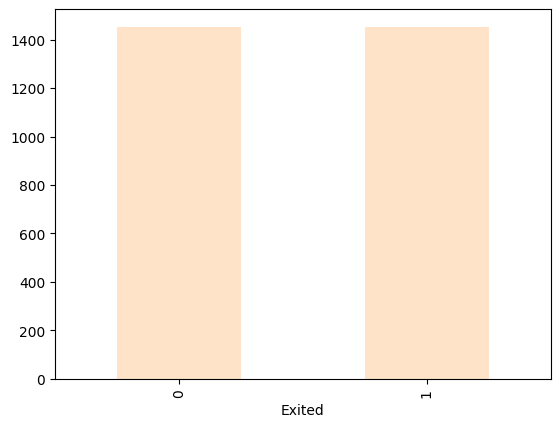

In [630]:
churned_under_plt = train_under["Exited"].value_counts()
churned_under_plt.plot(kind="bar")
plt.show()

In [631]:
X_train_under = train_under.drop(columns = ["Exited"])
y_train_under = train_under["Exited"]

In [632]:
final_gb_under = GradientBoostingClassifier (n_estimators= 300, min_samples_split= 10, min_samples_leaf= 1, max_depth= 7, learning_rate= 0.01, random_state=0)#(max_depth= 3, max_leaf_nodes = 100, random_state=0)
final_gb_under.fit(X_train_under, y_train_under)


GradientBoostingClassifier(learning_rate=0.01, max_depth=7,
                           min_samples_split=10, n_estimators=300,
                           random_state=0)

In [633]:
y_pred_gb_under = final_gb_under.predict(X_test_scaled)
print("Undersampling Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_gb_under)* 100}%")
print(classification_report(y_test, y_pred_gb_under))

c:\Users\lored\Documents\Ironhack\Project\final_project\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


Undersampling Results:
Accuracy: 79.5%
              precision    recall  f1-score   support

           0       0.94      0.80      0.86      2416
           1       0.48      0.77      0.59       584

    accuracy                           0.80      3000
   macro avg       0.71      0.79      0.73      3000
weighted avg       0.85      0.80      0.81      3000



### SMOTE

In [634]:
sm = SMOTE(random_state = 1,sampling_strategy=1.0)

In [636]:
X_train_smote,y_train_smote = sm.fit_resample(X_train_scaled,y_train)

In [637]:
smote_gbc = GradientBoostingClassifier (n_estimators= 300, min_samples_split= 10, min_samples_leaf= 1, max_depth= 7, learning_rate= 0.01, random_state=0)#(max_depth=30, max_leaf_nodes=250, random_state=42)
smote_gbc.fit(X_train_smote, y_train_smote)

GradientBoostingClassifier(learning_rate=0.01, max_depth=7,
                           min_samples_split=10, n_estimators=300,
                           random_state=0)

In [638]:
y_pred_smote = smote_gbc.predict(X_test_scaled)
print("SMOTE Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_smote)*100}%")
print(classification_report(y_test, y_pred_smote))

SMOTE Results:
Accuracy: 86.73333333333333%
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      2416
           1       0.74      0.49      0.59       584

    accuracy                           0.87      3000
   macro avg       0.81      0.72      0.75      3000
weighted avg       0.86      0.87      0.86      3000

